In [10]:
# run this cell and restart before you continue. I faced issue with numpy 2.0.2
!pip uninstall -y numpy
!pip install numpy==1.26.4

In [3]:
import numpy
print(f"  - NumPy version is {numpy.__version__}, not 1.26.4!")
# Make sure it's not version 2.x

  - NumPy version is 1.26.4, not 1.26.4!


In [2]:
# =====================================================================================
#  MAIN PIPELINE NOTEBOOK - CELL 1 (FINAL & CORRECTED)
#  This version uses a two-step install AND controls pip's upgrade strategy.
# =====================================================================================
import subprocess
import sys

def run_command(command, description):
    """A helper function to run a shell command and report its status."""
    print(f"🔹 {description}...")
    try:
        subprocess.run(
            f"{command}", shell=True, check=True, capture_output=True, text=True, timeout=600
        )
        print("✅ Success!")
        return True
    except Exception as e:
        print(f"❌ ERROR: {description} failed.")
        if hasattr(e, 'stderr'): print(e.stderr)
        return False

print("🚀 STARTING FINAL, CORRECTED INSTALLATION...")
print("-" * 50)

# --- Step 1: System Tools ---
print("STEP 1: Installing AutoDock Vina & Open Babel...")
sys_ok = run_command("apt-get update -qq && apt-get install -y -qq autodock-vina openbabel", "Installing system tools")

# --- Step 2: Force Install NumPy 1.x ---
print("\nSTEP 2: Pinning NumPy to version 1.26.4...")
pip_command = f"{sys.executable} -m pip install --quiet"
numpy_ok = run_command(f"{pip_command} numpy==1.26.4", "Installing numpy==1.26.4")

# --- Step 3: Install Remaining Packages with a Safe Upgrade Strategy ---
print("\nSTEP 3: Installing other packages while protecting NumPy...")
other_packages = [
    "pandas", "matplotlib", "seaborn", "biopython", "requests",
    "rdkit-pypi", "torch", "transformers==4.30.2", "tokenizers", "openpyxl", "plotly"
]
# THE KEY FIX: --upgrade-strategy only-if-needed tells pip not to touch numpy
# if the installed version (1.26.4) already satisfies the dependencies.
other_ok = run_command(f"{pip_command} --upgrade-strategy only-if-needed {' '.join(other_packages)}", "Installing remaining libraries")

# --- Step 4: Verification ---
print("\nSTEP 4: Verifying installations...")
all_good = sys_ok and numpy_ok and other_ok

try:
    import numpy
    print(f"✅ NumPy version successfully installed: {numpy.__version__}")
    if not numpy.__version__.startswith('1.26'):
        print(f"  - ❌ CRITICAL: NumPy version is {numpy.__version__}, not 1.26.4!")
        all_good = False

    import rdkit, transformers
    print("✅ RDKit and other Python libraries imported successfully.")
except ImportError as e:
    print(f"❌ Python library import failed: {e}")
    all_good = False

for tool in ['vina', 'obabel']:
    if subprocess.run(['which', tool], capture_output=True).returncode == 0:
        print(f"✅ Command-line tool '{tool}' found.")
    else:
        print(f"❌ Command-line tool '{tool}' not found.")
        all_good = False

print("=" * 50)
if all_good:
    print("🎉🎉🎉 MAIN PIPELINE ENVIRONMENT READY! 🎉🎉🎉")
    print("The NumPy incompatibility has been definitively resolved.")
else:
    print("⚠️ Installation failed. Please review errors.")
print("=" * 50)

🚀 STARTING FINAL, CORRECTED INSTALLATION...
--------------------------------------------------
STEP 1: Installing AutoDock Vina & Open Babel...
🔹 Installing system tools...
✅ Success!

STEP 2: Pinning NumPy to version 1.26.4...
🔹 Installing numpy==1.26.4...
✅ Success!

STEP 3: Installing other packages while protecting NumPy...
🔹 Installing remaining libraries...
✅ Success!

STEP 4: Verifying installations...
✅ NumPy version successfully installed: 1.26.4
✅ RDKit and other Python libraries imported successfully.
✅ Command-line tool 'vina' found.
✅ Command-line tool 'obabel' found.
🎉🎉🎉 MAIN PIPELINE ENVIRONMENT READY! 🎉🎉🎉
The NumPy incompatibility has been definitively resolved.


In [2]:
# =====================================================================================
#  MAIN PIPELINE NOTEBOOK - CELL 2
#  Robust Sequence Generation
# =====================================================================================
import os
import torch
from transformers import AutoModelForCausalLM
from tokenizers import Tokenizer
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import time

class SequenceGeneration:
    """
    A dedicated class to handle the generation and validation of a candidate enzyme sequence.
    """
    def __init__(self):
        print("🔹 Initializing sequence generation module...")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model_name = "hugohrban/progen2-medium"
        self.target_family = "GH11"
        self.num_candidates = 3
        self.max_length = 512

        # Data for the correct prompting strategy
        self.TAGS = {"GH11": "<|GH11|>"}
        self.PROMPT_FRAGMENTS = {"GH11": "MKYLLPTAAFCLVSCLALAA"}

        self.paths = {
            "sequences_dir": "data/sequences",
            "final_sequence_fasta": "data/sequences/validated_xylanase.fasta",
        }

        print("  - Loading ProGen2 model and tokenizer (this may take a minute)...")
        self.model = AutoModelForCausalLM.from_pretrained(self.model_name, trust_remote_code=True).to(self.device)
        self.tokenizer = Tokenizer.from_pretrained(self.model_name)
        self.tokenizer.no_padding()
        print("✅ Initialization complete. Model is ready.")

    def _generate_token_by_token(self, tag, seed_fragment):
        """Generates sequences using the robust, token-by-token method."""
        prompt = f"MASK_START {tag} {seed_fragment}"
        print(f"\n🔹 Generating sequences with prompt: '{prompt}'...")
        input_ids = self.tokenizer.encode(prompt).ids
        input_ids = torch.tensor(input_ids).unsqueeze(0).to(self.device)

        decoded_sequences = []
        for i in range(self.num_candidates):
            print(f"  - Generating candidate {i+1}/{self.num_candidates}...")
            generated_tensor = input_ids.clone()
            with torch.no_grad():
                for _ in range(self.max_length - input_ids.size(1)):
                    outputs = self.model(generated_tensor)
                    next_token_logits = outputs.logits[:, -1, :]
                    probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
                    next_token = torch.multinomial(probs, num_samples=1)
                    generated_tensor = torch.cat((generated_tensor, next_token), dim=1)
                    if next_token.item() == self.tokenizer.token_to_id(""):
                        break
            decoded_sequences.append(self.tokenizer.decode(generated_tensor[0].tolist()))
        return decoded_sequences

    def _clean_and_validate(self, raw_sequences):
        """Cleans and validates generated sequences to select the best one."""
        print("\n🔹 Cleaning and validating generated sequences...")
        protein_chars = set("ACDEFGHIKLMNPQRSTVWY")
        for i, raw_seq in enumerate(raw_sequences):
            sequence_start = raw_seq.find('M')
            if sequence_start == -1: continue

            clean_seq = "".join([c for c in raw_seq[sequence_start:].upper() if c in protein_chars])
            seq_len, unique_aa = len(clean_seq), len(set(clean_seq))
            print(f"  - Candidate {i+1}: Length={seq_len}, Amino Acid Diversity={unique_aa}")

            if (200 <= seq_len <= 600) and (unique_aa >= 18):
                print(f"  ✅ Candidate {i+1} passed validation. Selecting this sequence.")
                return clean_seq
        print("  ❌ No generated sequences passed our validation criteria.")
        return None

    def run(self):
        """Main workflow: Generate, Validate, Select, and Save."""
        os.makedirs(self.paths['sequences_dir'], exist_ok=True)
        tag = self.TAGS[self.target_family]
        fragment = self.PROMPT_FRAGMENTS[self.target_family]

        raw_sequences = self._generate_token_by_token(tag, fragment)
        if not raw_sequences:
            print("  ❌ FAILED: Generation produced no output.")
            return None

        final_sequence = self._clean_and_validate(raw_sequences)
        if final_sequence:
            print(f"\n🔹 Saving selected sequence ({len(final_sequence)} aa) to FASTA file...")
            record = SeqRecord(Seq(final_sequence), id=f"{self.target_family}_validated_01", description="AI-generated and validated sequence")
            output_file = self.paths['final_sequence_fasta']
            SeqIO.write(record, output_file, "fasta")
            print(f"  ✅ Sequence saved to: {output_file}")
            return output_file
        return None

# --- Run the full, robust sequence generation process ---
start_time = time.time()
seq_gen = SequenceGeneration()
final_fasta_path = seq_gen.run()
end_time = time.time()

print("\n" + "="*50)
if final_fasta_path:
    print(f"✅ SEQUENCE GENERATION COMPLETED in {end_time - start_time:.2f} seconds.")
    print(f"   A validated enzyme sequence is ready in '{final_fasta_path}'")
else:
    print("❌ SEQUENCE GENERATION FAILED.")
print("="*50)

🔹 Initializing sequence generation module...
  - Loading ProGen2 model and tokenizer (this may take a minute)...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_progen.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/hugohrban/progen2-medium:
- configuration_progen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_progen.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/hugohrban/progen2-medium:
- modeling_progen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

✅ Initialization complete. Model is ready.

🔹 Generating sequences with prompt: 'MASK_START <|GH11|> MKYLLPTAAFCLVSCLALAA'...
  - Generating candidate 1/3...
  - Generating candidate 2/3...
  - Generating candidate 3/3...

🔹 Cleaning and validating generated sequences...
  - Candidate 1: Length=496, Amino Acid Diversity=20
  ✅ Candidate 1 passed validation. Selecting this sequence.

🔹 Saving selected sequence (496 aa) to FASTA file...
  ✅ Sequence saved to: data/sequences/validated_xylanase.fasta

✅ SEQUENCE GENERATION COMPLETED in 228.36 seconds.
   A validated enzyme sequence is ready in 'data/sequences/validated_xylanase.fasta'


In [5]:
# =====================================================================================
#  MAIN PIPELINE NOTEBOOK - CELL 3
#  Ligand Preparation
# =====================================================================================
import os
import subprocess
from rdkit import Chem
from rdkit.Chem import AllChem

class LigandPreparation:
    """
    A dedicated class to handle the preparation of the ligand from a SMILES string
    into a dockable PDBQT file.
    """
    def __init__(self):
        print("🔹 Initializing ligand preparation module...")
        self.ligand_name = "xylobiose"
        self.ligand_smiles = "C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O[C@@H]2[C@H](O[C@H]([C@@H]([C@H]2O)O)O)CO)O)O)O)O"

        self.paths = {
            "ligands_dir": "data/ligands",
            "ligand_sdf": f"data/ligands/{self.ligand_name}.sdf",
            "ligand_pdbqt": f"data/ligands/{self.ligand_name}.pdbqt",
        }
        os.makedirs(self.paths['ligands_dir'], exist_ok=True)
        print("✅ Initialization complete.")

    def run(self):
        """
        Main workflow: Converts SMILES to a 3D structure, then to PDBQT.
        Returns the path to the final PDBQT file if successful.
        """
        print(f"\n🔹 Preparing ligand '{self.ligand_name}'...")
        try:
            # Step 1: Generate 3D structure from SMILES using RDKit
            print("  - Step 1/2: Generating 3D structure with RDKit...")
            mol = Chem.MolFromSmiles(self.ligand_smiles)
            mol = Chem.AddHs(mol) # Add hydrogens, crucial for charges and geometry
            AllChem.EmbedMolecule(mol, AllChem.ETKDGv3())
            AllChem.MMFFOptimizeMolecule(mol) # Optimize the geometry

            sdf_file = self.paths['ligand_sdf']
            writer = Chem.SDWriter(sdf_file)
            writer.write(mol)
            writer.close()
            print(f"    - Saved 3D structure to: {sdf_file}")

            # Step 2: Convert 3D structure (SDF) to PDBQT using Open Babel
            print("  - Step 2/2: Converting to PDBQT with Open Babel...")
            pdbqt_file = self.paths['ligand_pdbqt']
            # The '-O' flag tells obabel to determine output format from the extension.
            # Open Babel correctly calculates charges and atom types for PDBQT.
            cmd = ["obabel", sdf_file, "-O", pdbqt_file]
            subprocess.run(cmd, check=True, capture_output=True, text=True)

            if os.path.exists(pdbqt_file) and os.path.getsize(pdbqt_file) > 0:
                print(f"    - Saved final dockable ligand to: {pdbqt_file}")
                return pdbqt_file
            else:
                raise FileNotFoundError("Open Babel ran, but PDBQT file was not created.")

        except Exception as e:
            print(f"  ❌ FAILED: Ligand preparation failed.")
            print(f"     Error: {e}")
            return None

# --- Run the ligand preparation process ---
ligand_prep = LigandPreparation()
final_ligand_path = ligand_prep.run()

print("\n" + "="*50)
if final_ligand_path:
    print("✅ LIGAND PREPARATION COMPLETED.")
    print(f"   The dockable ligand file is ready at: '{final_ligand_path}'")
else:
    print("❌ LIGAND PREPARATION FAILED.")
print("="*50)

🔹 Initializing ligand preparation module...
✅ Initialization complete.

🔹 Preparing ligand 'xylobiose'...
  - Step 1/2: Generating 3D structure with RDKit...
    - Saved 3D structure to: data/ligands/xylobiose.sdf
  - Step 2/2: Converting to PDBQT with Open Babel...
    - Saved final dockable ligand to: data/ligands/xylobiose.pdbqt

✅ LIGAND PREPARATION COMPLETED.
   The dockable ligand file is ready at: 'data/ligands/xylobiose.pdbqt'


In [4]:
# =====================================================================================
#  MAIN PIPELINE NOTEBOOK - CELL 4
#  Manual Intervention Point: Download Sequence for ColabFold
# =====================================================================================
from google.colab import files

# --- This is the file we need to transfer to the other notebook ---
fasta_file_to_download = "data/sequences/validated_xylanase.fasta"

print("="*60)
print("             MANUAL INTERVENTION POINT")
print("="*60)
print("\nOur main pipeline has generated two key files so far:")
print("  1. An AI-generated enzyme sequence: data/sequences/validated_xylanase.fasta")
print("  2. A prepared ligand for docking:   data/ligands/xylobiose.pdbqt")
print("\nOur next task is to predict the 3D structure of the enzyme.")
print("To do this reliably, we will use a separate, dedicated Colab notebook.")
print("\nACTION REQUIRED:")
print(f"  1. Click the link below to download the FASTA file to your computer.")
print(f"  2. Open the 'Dedicated Structure Prediction Notebook'.")
print(f"  3. Follow the instructions in that notebook to upload this file and run ColabFold.")
print("\n" + "="*60)

# --- Provide a download link for the user ---
try:
    files.download(fasta_file_to_download)
except FileNotFoundError:
    print(f"\n❌ ERROR: Cannot find the file '{fasta_file_to_download}'.")
    print("   Please make sure the previous cell (Sequence Generation) was run successfully.")

             MANUAL INTERVENTION POINT

Our main pipeline has generated two key files so far:
  1. An AI-generated enzyme sequence: data/sequences/validated_xylanase.fasta
  2. A prepared ligand for docking:   data/ligands/xylobiose.pdbqt

Our next task is to predict the 3D structure of the enzyme.
To do this reliably, we will use a separate, dedicated Colab notebook.

ACTION REQUIRED:
  1. Click the link below to download the FASTA file to your computer.
  2. Open the 'Dedicated Structure Prediction Notebook'.
  3. Follow the instructions in that notebook to upload this file and run ColabFold.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🔹 Initializing molecular docking module...
✅ Initialization complete.

🔹 [Step 0/5] Cleaning up results from previous runs...
  - Removed old file: data/structures/receptor.pdbqt
  - Removed old file: data/docking/vina_docking.log
  - Removed old file: data/docking/docking_poses.pdbqt
  ✅ Cleanup complete.

🔹 [Step 1/5] Preparing receptor (PDB -> PDBQT)...
  - Using receptor file: GH11_validated_01_25954_unrelaxed_rank_001_alphafold2_ptm_model_5_seed_000.pdb
  ✅ Receptor prepared: data/structures/receptor.pdbqt

🔹 [Step 2/5] Defining docking search area...
  ✅ Protein center: (x=7.85, y=-17.99, z=-12.29)

🔹 [Step 3/5] Running AutoDock Vina docking simulation...
  ✅ Docking simulation completed successfully.

🔹 [Step 4/5] Analyzing and plotting results...
  ✅ Docking results saved to: results/docking_summary.csv

Docking Summary:
 Mode  Affinity (kcal/mol)
    1               -6.012
    2               -5.890
    3               -5.629
    4               -5.103
    5               -5.0

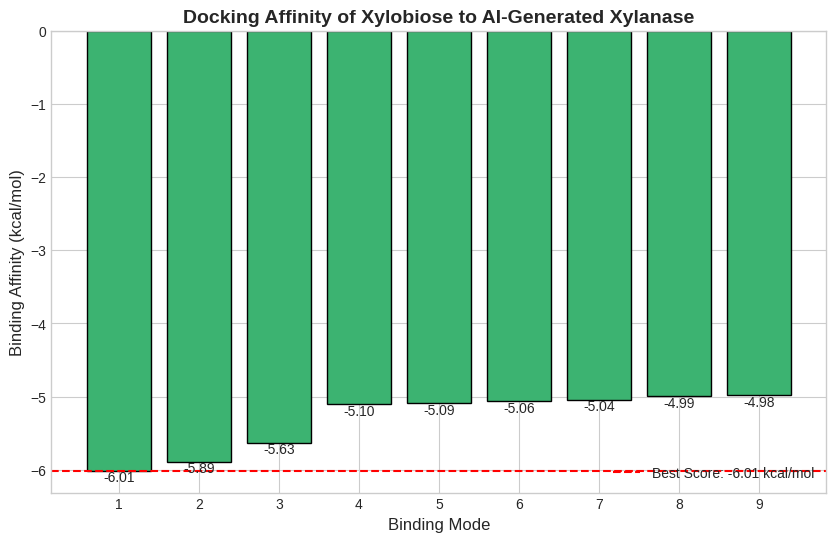

In [6]:
# =====================================================================================
#  MAIN PIPELINE NOTEBOOK - CELL 5 (FINAL VERSION with Robust Parser)
# =====================================================================================
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

class MolecularDocking:
    """
    Handles the final docking steps, including cleanup and robust results parsing.
    """
    def __init__(self):
        print("🔹 Initializing molecular docking module...")
        self.paths = {
            "structures_dir": "data/structures", "docking_dir": "data/docking",
            "results_dir": "results", "plots_dir": "plots",
            "uploaded_pdb": next((f for f in os.listdir('.') if f.endswith('.pdb')), None),
            "receptor_pdbqt": "data/structures/receptor.pdbqt",
            "ligand_pdbqt": "data/ligands/xylobiose.pdbqt",
            "docking_log": "data/docking/vina_docking.log",
            "docking_out": "data/docking/docking_poses.pdbqt",
            "results_csv": "results/docking_summary.csv",
            "results_plot": "plots/docking_affinity_plot.png"
        }
        for key, path in self.paths.items():
            if "dir" in key: os.makedirs(path, exist_ok=True)
        print("✅ Initialization complete.")

    def _cleanup(self):
        """Removes files from previous runs to ensure a clean slate."""
        print("\n🔹 [Step 0/5] Cleaning up results from previous runs...")
        files_to_delete = [
            self.paths['receptor_pdbqt'], self.paths['docking_log'],
            self.paths['docking_out'], self.paths['results_csv'], self.paths['results_plot']
        ]
        for f in files_to_delete:
            if os.path.exists(f): os.remove(f); print(f"  - Removed old file: {f}")
        print("  ✅ Cleanup complete.")

    def _prepare_receptor(self):
        """Prepares the receptor PDBQT from the already uploaded PDB file."""
        print("\n🔹 [Step 1/5] Preparing receptor (PDB -> PDBQT)...")
        if not self.paths["uploaded_pdb"]:
            print("  ❌ FAILED: Could not find uploaded PDB. Please re-run the upload cell."); return None
        print(f"  - Using receptor file: {self.paths['uploaded_pdb']}")
        try:
            cmd = ["obabel", self.paths["uploaded_pdb"], "-O", self.paths['receptor_pdbqt'], "-xr"]
            subprocess.run(cmd, check=True, capture_output=True, text=True)
            print(f"  ✅ Receptor prepared: {self.paths['receptor_pdbqt']}"); return self.paths['receptor_pdbqt']
        except Exception as e: print(f"  ❌ FAILED: Receptor preparation failed. Error: {e}"); return None

    def _define_binding_box(self):
        """Calculates the geometric center of the protein."""
        print("\n🔹 [Step 2/5] Defining docking search area...")
        try:
            coords = [
                [float(line[30:38]), float(line[38:46]), float(line[46:54])]
                for line in open(self.paths["uploaded_pdb"]) if line.startswith('ATOM')
            ]
            center = np.mean(coords, axis=0)
            print(f"  ✅ Protein center: (x={center[0]:.2f}, y={center[1]:.2f}, z={center[2]:.2f})"); return center
        except Exception as e: print(f"  ❌ FAILED: Could not calculate protein center. Error: {e}"); return None

    def _run_vina_docking(self, box_center):
        """Executes AutoDock Vina."""
        print("\n🔹 [Step 3/5] Running AutoDock Vina docking simulation...")
        try:
            cmd = [
                "vina", "--receptor", self.paths['receptor_pdbqt'], "--ligand", self.paths['ligand_pdbqt'],
                "--center_x", str(box_center[0]), "--center_y", str(box_center[1]), "--center_z", str(box_center[2]),
                "--size_x", "25", "--size_y", "25", "--size_z", "25",
                "--exhaustiveness", "16", "--out", self.paths['docking_out']
            ]
            result = subprocess.run(cmd, check=True, capture_output=True, text=True)
            with open(self.paths['docking_log'], 'w') as f: f.write(result.stdout)
            print("  ✅ Docking simulation completed successfully."); return self.paths['docking_log']
        except Exception as e:
            print(f"  ❌ FAILED: Vina docking simulation failed.");
            if hasattr(e, 'stderr'): print(f"     Error: {e.stderr}"); return None

    def analyze_and_plot_results(self, log_file):
        """
        NEW ROBUST VERSION: Parses the Vina log file to extract and display results.
        Uses a try-except block to safely ignore non-data lines.
        """
        print("\n🔹 [Step 4/5] Analyzing and plotting results...")
        results = []
        try:
            with open(log_file, 'r') as f:
                for line in f:
                    parts = line.split()
                    # A results line must have at least 2 parts (mode and affinity)
                    if len(parts) < 2:
                        continue
                    try:
                        # Attempt to convert the parts to the correct data types
                        mode = int(parts[0])
                        affinity = float(parts[1])
                        # If successful, it's a valid results line
                        results.append({'Mode': mode, 'Affinity (kcal/mol)': affinity})
                    except (ValueError, IndexError):
                        # If conversion fails, it's a header or decorative line. Ignore it.
                        continue

            if not results: print("❌ Could not parse any results from the log file."); return

            df = pd.DataFrame(results)
            df.to_csv(self.paths['results_csv'], index=False)
            print(f"  ✅ Docking results saved to: {self.paths['results_csv']}")
            print("\nDocking Summary:")
            print(df.to_string(index=False))

            plt.style.use('seaborn-v0_8-whitegrid')
            fig, ax = plt.subplots(figsize=(10, 6))
            bars = ax.bar(df['Mode'], df['Affinity (kcal/mol)'], color='mediumseagreen', edgecolor='black')
            ax.set_xlabel('Binding Mode', fontsize=12); ax.set_ylabel('Binding Affinity (kcal/mol)', fontsize=12)
            ax.set_title('Docking Affinity of Xylobiose to AI-Generated Xylanase', fontsize=14, weight='bold')
            ax.set_xticks(df['Mode']); ax.bar_label(bars, fmt='%.2f')
            best_score = df['Affinity (kcal/mol)'].min()
            plt.axhline(y=best_score, color='red', linestyle='--', label=f'Best Score: {best_score:.2f} kcal/mol')
            plt.legend()
            plt.savefig(self.paths['results_plot'], dpi=300, bbox_inches='tight')
            print(f"\n  ✅ Results plot saved to: {self.paths['results_plot']}")

            print("\n🔹 [Step 5/5] Evaluation:")
            if best_score <= -7.0: print("  🎉 EXCELLENT BINDING: A very strong interaction is predicted.")
            elif best_score <= -5.0: print("  ✅ GOOD BINDING: A favorable interaction is predicted.")
            else: print("  ⚠️ MODERATE/WEAK BINDING: The interaction may not be very strong.")
        except Exception as e: print(f"❌ FAILED: Could not analyze results. Error: {e}")

# --- Run the final docking and analysis process ---
docking_step = MolecularDocking()
docking_step._cleanup()
receptor_pdbqt = docking_step._prepare_receptor()
if receptor_pdbqt:
    binding_center = docking_step._define_binding_box()
    if binding_center is not None:
        vina_log = docking_step._run_vina_docking(binding_center)
        if vina_log:
            docking_step.analyze_and_plot_results(vina_log)
            print("\n" + "="*50)
            print("🎉🎉🎉 PIPELINE COMPLETE! 🎉🎉🎉")
            print("="*50)